In [13]:
%%html
<marquee style='width: 40%; color: Red;'> This is the Azhar's Colab Notebook </marquee>
< == <marquee style='width: 50%; color: Black;'>Classification Problem Using Mnist dataset</marquee>

In [1]:
# All the imports!
import tensorflow as tf # tested with 1.14.0
import numpy as np # tested with 1.16.4
import matplotlib.pyplot as plt #tested with 3.0.3
from sklearn.metrics import classification_report # tested with 0.21.2l

# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True

# Fetch "Fashion MNIST" data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# A good rule of thumb is to normalise input values - i.e. transform them to a
# scale of 0 to 1. Each element in this dataset is a pixel value of 0 to 255, so
# we'll normalise / rescale these values.
x_train = x_train / 255.0
x_test = x_test / 255.0

# Map for human readable class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4423680/4422102 [==============================] - 0s 0us/step



**Get data shapes**

We are expecting 60000 training images and 10000 test images, where each image is comprised of 28x28 greyscale pixel values.

In addition we have the classes to which each image belongs. These are held in seperate files.

In [14]:
print("Shape of Training Image Data: " + str(x_train.shape))
print("Shape of Training Class Data: " + str(y_train.shape))
print("Shape of Test Image Data: " + str(x_test.shape))
print("Shape of Test Class Data: " + str(y_test.shape))

Shape of Training Image Data: (60000, 28, 28)
Shape of Training Class Data: (60000,)
Shape of Test Image Data: (10000, 28, 28)
Shape of Test Class Data: (10000,)



## Visualise first 25 images from training data

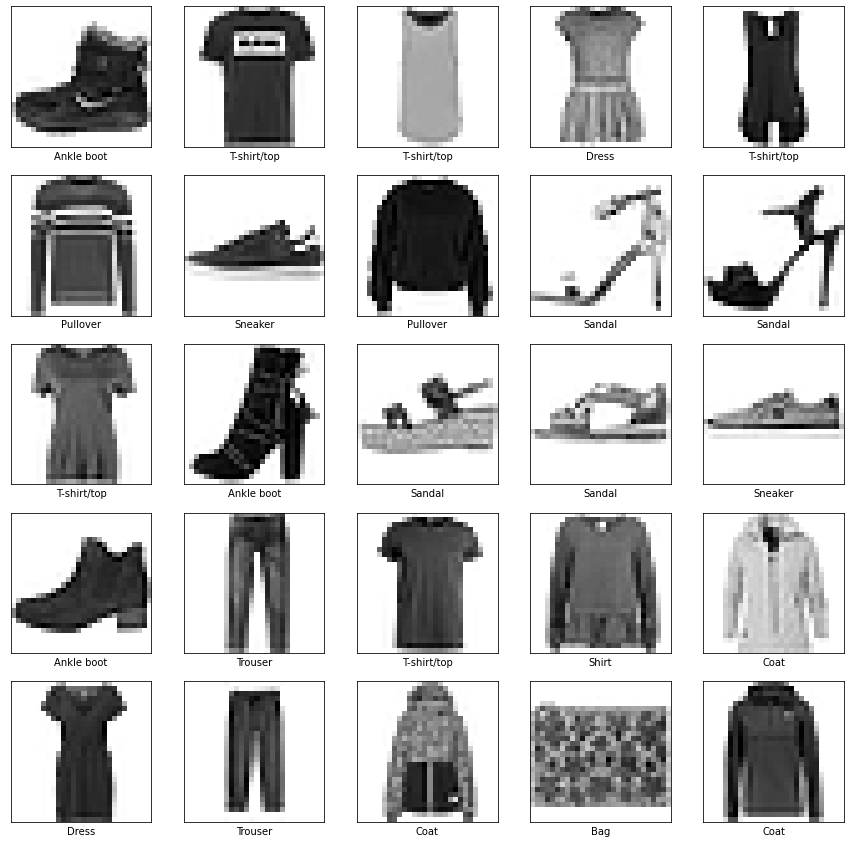

In [15]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()


## **Visualise image with pixel values**

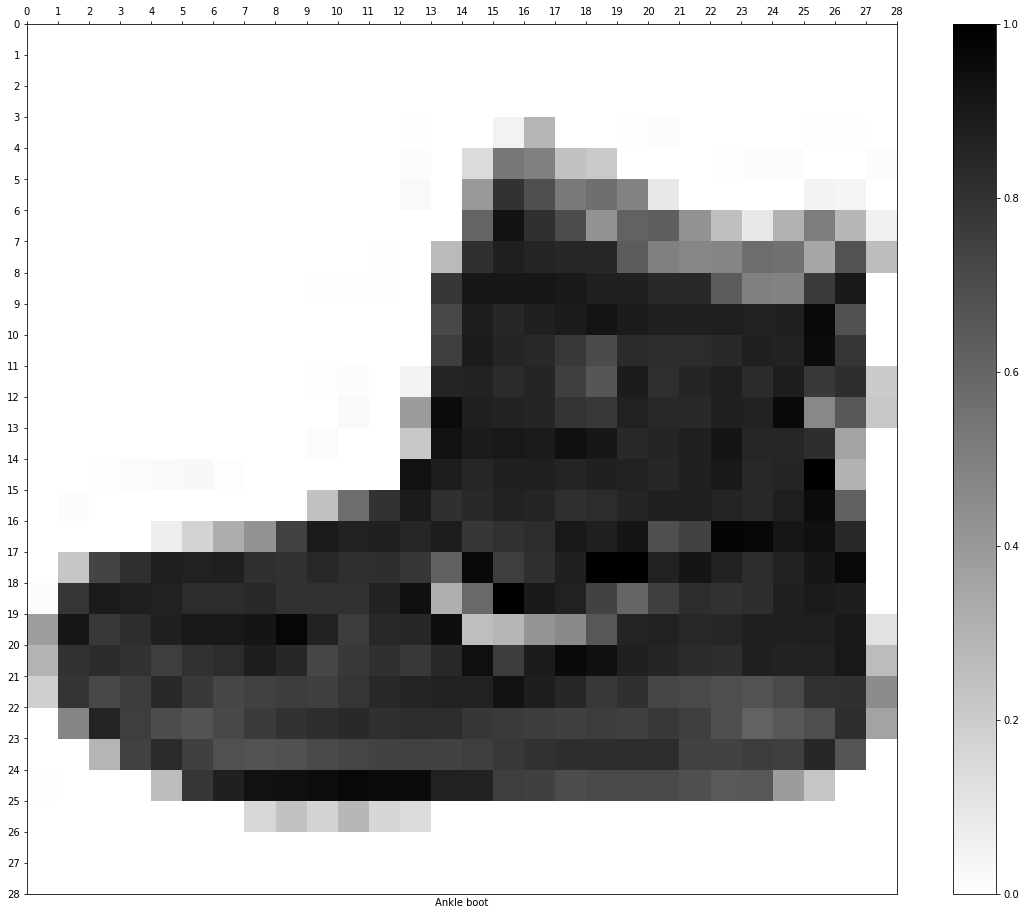

In [16]:
# Lets view the first image and classname in the dataset 
# Tip: Change "index" value to view different images.
index = 0
plt.figure(figsize=(20,16))
plt.imshow(x_train[index], cmap=plt.cm.binary)
plt.xlabel(class_names[y_train[index]])
plt.colorbar()
#plt.grid(True)
#plt.rc('grid', linestyle="-", color='fuchsia')

ax = plt.gca()
ax.set_xticks(np.arange(-.5, 28, 1))
ax.set_yticks(np.arange(-.5, 28, 1))
ax.set_xticklabels(np.arange(0, 29, 1))
ax.set_yticklabels(np.arange(0, 29, 1))
ax.xaxis.tick_top()

# Adds Pixel Values on top of image
#for i in range(28):
#    for j in range(28):
#        text = ax.text(j, i, round(x_train[index][i, j], 2),
#                       ha="center", va="center", color="fuchsia")
        
        
plt.show()


# Create and build Convolutional Neural Network

In [17]:
# We begin by defining the a empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()

# We start with a convolutional layer this will extract features from 
# the input images by sliding a convolution filter over the input image, 
# resulting in a feature map.
model.add(
    tf.keras.layers.Conv2D(
        filters=32, # How many filters we will learn 
        kernel_size=(3, 3), # Size of feature map that will slide over image
        strides=(1, 1), # How the feature map "steps" across the image
        padding='valid', # We are not using padding
        activation='relu', # Rectified Linear Unit Activation Function
        input_shape=(28, 28, 1) # The expected input shape for this layer
    )
) 

# The next layer we will add is a Maxpooling layer. This will reduce the 
# dimensionality of each feature, which reduces the number of parameters that 
# the model needs to learn, which shortens training time.
model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), # Size feature will be mapped to
        strides=(2, 2) # How the pool "steps" across the feature
    )
)
          
# We'll now add a dropout layer. This fights overfitting and forces the model to 
# learn multiple representations of the same data by randomly disabling neurons 
# in the learning phase.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# Output from previous layer is a 3D tensor. This must be flattened to a 1D 
# vector before beiung fed to the Dense Layers.
model.add(
    tf.keras.layers.Flatten()
)

# A dense (interconnected) layer is added for mapping the derived features 
# to the required class.
model.add(
    tf.keras.layers.Dense(
        units=128, # Output shape
        activation='relu' # Rectified Linear Unit Activation Function
    )
)

# Final layer with 10 outputs and a softmax activation. Softmax activation 
# enables me to calculate the output based on the probabilities. 
# Each class is assigned a probability and the class with the maximum 
# probability is the model’s output for the input.
model.add(
    tf.keras.layers.Dense(
        units=10, # Output shape
        activation='softmax' # Softmax Activation Function
    )
)

# Build the model
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimizer function
    metrics=['accuracy'] # reporting metric
)

# Display a summary of the models structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
__________________________________________________

**Visualise the Model**

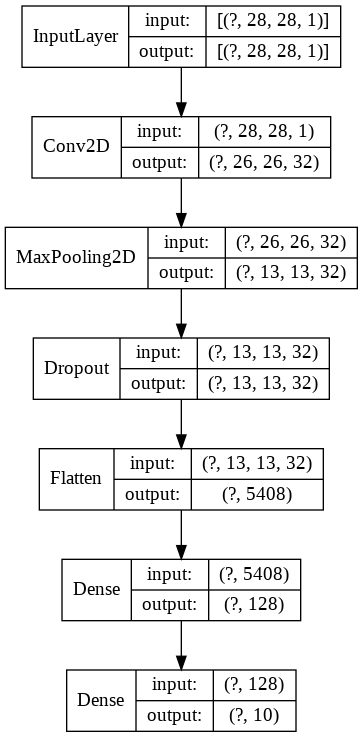

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

**Train the CNN**

In [19]:
# Add an empty color dimension as the Convolutional net is expecting this
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Train the CNN on the training data
history = model.fit(
    
      # Training data : features (images) and classes.
      x_train, y_train,
                    
      # number of samples to work through before updating the 
      # internal model parameters via back propagation.
      batch_size=256, 

      # An epoch is an iteration over the entire training data.
      epochs=10, 

      # The model will set apart his fraction of the training 
      # data, will not train on it, and will evaluate the loss
      # and any model metrics on this data at the end of 
      # each epoch. 
      validation_split=0.2, 

      verbose=1)

Epoch 1/10
188/188 [==============================] - 22s 118ms/step - loss: 0.5455 - accuracy: 0.8108 - val_loss: 0.3871 - val_accuracy: 0.8608
Epoch 2/10
188/188 [==============================] - 22s 117ms/step - loss: 0.3558 - accuracy: 0.8753 - val_loss: 0.3425 - val_accuracy: 0.8763
Epoch 3/10
188/188 [==============================] - 22s 118ms/step - loss: 0.3121 - accuracy: 0.8887 - val_loss: 0.2966 - val_accuracy: 0.8948
Epoch 4/10
188/188 [==============================] - 27s 143ms/step - loss: 0.2849 - accuracy: 0.8979 - val_loss: 0.2833 - val_accuracy: 0.9006
Epoch 5/10
188/188 [==============================] - 22s 118ms/step - loss: 0.2679 - accuracy: 0.9041 - val_loss: 0.2871 - val_accuracy: 0.8977
Epoch 6/10
188/188 [==============================] - 22s 117ms/step - loss: 0.2480 - accuracy: 0.9109 - val_loss: 0.2676 - val_accuracy: 0.9043
Epoch 7/10
188/188 [==============================] - 22s 117ms/step - loss: 0.2352 - accuracy: 0.9144 - val_loss: 0.2543 - val_ac


**Evaluate model with test data and view results**

In [20]:
# Get Model Predictions for test data
predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.92      0.84      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.86      0.86      1000
       Dress       0.90      0.93      0.91      1000
        Coat       0.88      0.83      0.85      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.66      0.72      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.94      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.90     10000
weighted avg       0.91      0.91      0.90     10000



**View examples of incorrectly classified test data**

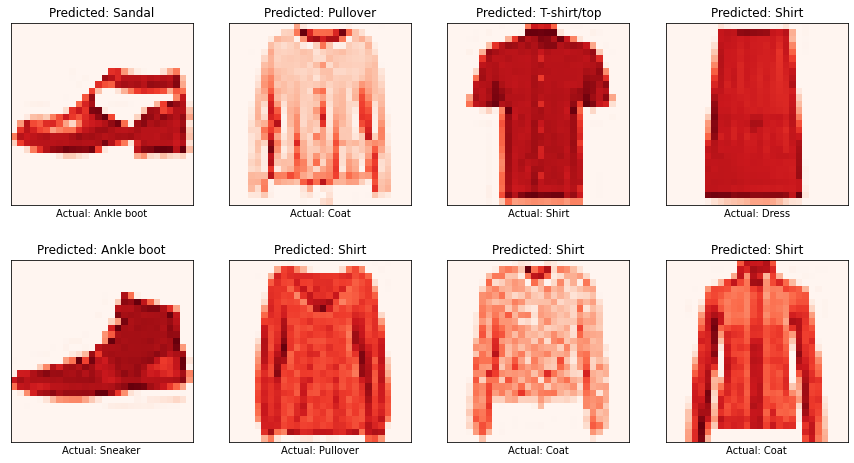

In [21]:
incorrect = np.nonzero(predicted_classes!=y_test)[0]

# Display the first 16 incorrectly classified images from the test data set
plt.figure(figsize=(15, 8))
for j, incorrect in enumerate(incorrect[0:8]):
    plt.subplot(2, 4, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[incorrect].reshape(28, 28), cmap="Reds")
    plt.title("Predicted: {}".format(class_names[predicted_classes[incorrect]]))
    plt.xlabel("Actual: {}".format(class_names[y_test[incorrect]]))

Print Feature Maps from the Convolutional Layer

Basically what we do here is to copy a slice of our trained model - the Conv2D Layer. We then feed in a test image and visualise the output from the Conv2D - our feature maps.

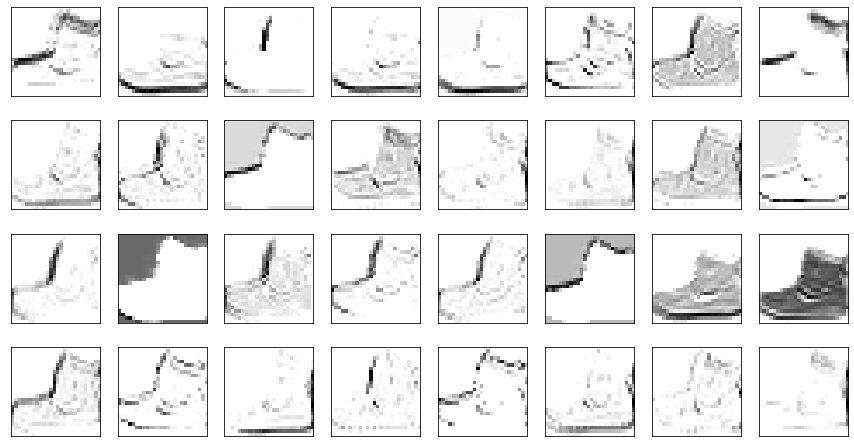

In [22]:
# The layer we want to copy from the trained CNN
layer_name = 'conv2d' 

# Get the list of layers for the existing model
layer_dict = {layer.name : layer for layer in model.layers}

# Create a copy of our existing model containing just the Conv2D Layer
modelslice = tf.keras.Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Choose an image (0 to 59999) from the training set
image = x_train[0] 

# Add the extra dimension expected by the slice
image = np.expand_dims(image, axis=0)

# Send the image through the model
feature_maps = modelslice.predict(image)

plt.figure(figsize=(15, 8))
    
# We are assuming that we have 32 feature maps
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(feature_maps[0, :, :, i-1], cmap=plt.cm.binary)